# Parallelized Global Ligand Docking with `dask.distributed.as_completed` and `pyrosetta.distributed`

*Note:* This Jupyter notebook uses parallelization and is **not** meant to be executed within a Google Colab environment.

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.dask
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys

from dask.distributed import Client, as_completed
from dask_jobqueue import SLURMCluster
from IPython import display

if 'google.colab' in sys.modules:
    print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
    sys.exit(0)

/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent functio

Setup PyRosetta command line flags:

In [2]:
ligand_params = "inputs/TPA.am1-bcc.fa.params"
flags = f"""
-extra_res_fa {ligand_params}
-ignore_unrecognized_res 1
-out:level 200
"""
pyrosetta.distributed.init(flags)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-extra_res_fa inputs/TPA.am1-bcc.fa.params -ignore_unrecognized_res 1 -out:level 200', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


Setup input pose as `PackedPose` object:

In [3]:
pose_obj = io.pose_from_file(filename="inputs/test_lig.pdb")

Setup global ligand docking RosettaScripts protocol within `pyrosetta.distributed`:

In [8]:
xml = """
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
  </SCOREFXNS>
  <RESIDUE_SELECTORS>
    <Chain name="chX" chains="X"/>
  </RESIDUE_SELECTORS>
  <SIMPLE_METRICS>
    <RMSDMetric name="rmsd_chX" residue_selector="chX" reference_name="store_native" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
  </SIMPLE_METRICS>
  <SCORINGGRIDS ligand_chain="X" width="25">
    <ClassicGrid grid_name="vdw" weight="1.0"/>
  </SCORINGGRIDS>
  <LIGAND_AREAS>
    <LigandArea name="docking_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true" minimize_ligand="10"/>
    <LigandArea name="final_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true"/>
    <LigandArea name="final_backbone_X" chain="X" cutoff="7.0" add_nbr_radius="false" all_atom_mode="true" Calpha_restraints="0.3"/>
  </LIGAND_AREAS>
  <INTERFACE_BUILDERS>
    <InterfaceBuilder name="side_chain_for_docking" ligand_areas="docking_sidechain_X"/>
    <InterfaceBuilder name="side_chain_for_final" ligand_areas="final_sidechain_X"/>
    <InterfaceBuilder name="backbone" ligand_areas="final_backbone_X" extension_window="3"/>
  </INTERFACE_BUILDERS>
  <MOVEMAP_BUILDERS>
    <MoveMapBuilder name="docking" sc_interface="side_chain_for_docking" minimize_water="true"/>
    <MoveMapBuilder name="final" sc_interface="side_chain_for_final" bb_interface="backbone" minimize_water="true"/>
  </MOVEMAP_BUILDERS>
  <MOVERS>
    <SavePoseMover name="spm" restore_pose="0" reference_name="store_native"/>
    <Transform name="transform" chain="X" box_size="20.0" move_distance="10" angle="360" initial_perturb="2" cycles="500" repeats="5" temperature="1000"/>
    <HighResDocker name="high_res_docker" cycles="9" repack_every_Nth="3" scorefxn="fa_standard" movemap_builder="docking"/>
    <FinalMinimizer name="final" scorefxn="fa_standard" movemap_builder="final"/>
  </MOVERS>
  <FILTERS>
      <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
      <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
  </FILTERS>
  <PROTOCOLS>
    <Add mover="spm"/>
    <Add mover="transform"/>
    <Add mover="high_res_docker"/>
    <Add mover="final"/>
    <Add filter="interfE"/>
    <Add filter="rmsd_chX"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""
xml_obj = rosetta_scripts.SingleoutputRosettaScriptsTask(xml)
xml_obj.setup()

Setup `dask` workers to run docking simulations:

In [9]:
if not os.getenv("DEBUG"):
    scratch_dir = os.path.join("/net/scratch", os.environ["USER"])
    cluster = SLURMCluster(cores=1,
                           processes=1,
                           job_cpu=1,
                           memory="3GB",
                           queue="interactive",
                           walltime="12:00:00",
                           local_directory=scratch_dir,
                           job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))],
                           extra=pyrosetta.distributed.dask.worker_extra(init_flags=flags))
    n_workers = 5
    cluster.scale(n_workers)
    client = Client(cluster)

/home/klimaj/anaconda3/envs/pyrosetta-bootcamp/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [10]:
if not os.getenv("DEBUG"):
    client

Client Scheduler: tcp://172.16.131.35:9559 Dashboard: http://172.16.131.35:1677/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Example using `dask.distributed.as_completed()` function:

"Give me at least 5 global ligand docks where the ligand RMSD is at least 0.4 Angstroms from the input ligand coordinates.":

After 15 dock(s), the lowest rmsd_chX is 0.47883597016334534


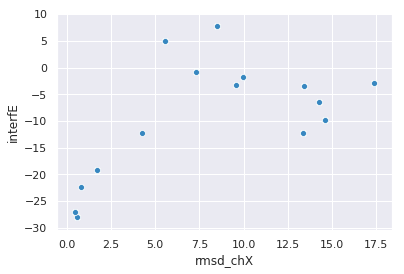

In [ ]:
if not os.getenv("DEBUG"):
    with seaborn.color_palette("Blues_d", n_colors=1):
        nstruct = n_workers
        futures = [client.submit(xml_obj, pose_obj) for j in range(nstruct)]
        seq = as_completed(futures, with_results=True)

        results = []
        for i, (future, result) in enumerate(seq, start=1):

            # Update dataset
            results.append(result)
            df = pd.DataFrame.from_records(packed_pose.to_dict(results))
            lowest_rmsd_chX = df["rmsd_chX"].sort_values().values[0]

            # Update display
            display.clear_output(wait=True)
            print(f"After {i} dock(s), the lowest rmsd_chX is {lowest_rmsd_chX}")
            seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)
            display.display(plt.gcf())

            # Submit more futures if condition is not met
            if (i >= nstruct) and (not lowest_rmsd_chX <= 0.4):
                nstruct += n_workers
                for j in range(n_workers):
                    seq.add(client.submit(xml_obj, pose_obj))

View resulting scores in the order they completed:

In [ ]:
df